## Background

In this notebook, I'll walk through an algorithm suggested by Claude to calculate the "squareness" of letters in a text image. This measure is calculated as:

<br>

$$\frac{\text{min(width, height)}}{\text{max(width, height)}}$$

<br>

Where $\text{width}$ and $\text{height}$ are the width and height of the rectangular bounding box around the letter.

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I’ll train a neural network for this task. This is one of many notebooks in my [**TypefaceClassifier** project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

In [9]:
#| code-fold: true
#| code-summary: "Show imports"
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import cv2

This is a very straightforward (code-wise) algorithm compared to some of the other ones I've worked through. In fact, this algorithm is just a slight modification to the [aspect ratio algorithm](https://vishalbakshi.github.io/blog/posts/2024-08-14-typefaceclassifier-aspect-ratio/). The aspect ratio is the ratio of bounding rectangle width to bounding rectangle length. This "squareness" ratio is the minimum dimension divided by the maximum dimension.

## Squareness Ratio Algorithm

We start by loading the image an calculating the `binary` (as always).

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
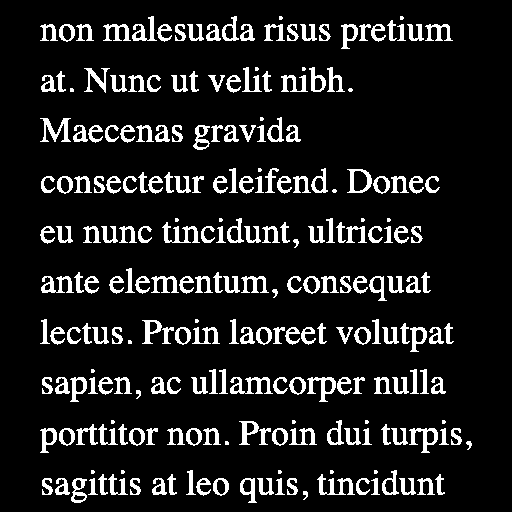

In [3]:
path = 'serif-36px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

We then find the contours in the image:

In [4]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

For each contour, we create a bounding rectangle and calculate the squareness ratio:

In [5]:
squareness_ratio = []

for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  squareness = min(w, h) / max(w, h)
  squareness_ratio.append(squareness)

Then calculate the average ratio across all contours:

In [6]:
average_squareness = np.median(squareness_ratio) if squareness_ratio else 0
average_squareness

0.8333333333333334

And that's it!

Squareness ratios that are close to 1 represent letter forms that are closer to a perfect square. Ratios closer to 0 represent letters that are closer to wide or tall rectangles.

## Squareness Ratio for Different Images

I'll wrap the squareness ratio algorithm in a function and then calculate the median ratio for `display` versus `serif` images.

In [18]:
def squareness_ratio(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    squareness_ratios = []

    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate squareness (ratio of width to height)
        # We use min/max to ensure the ratio is always between 0 and 1
        squareness = min(w, h) / max(w, h)

        squareness_ratios.append(squareness)

    # Calculate average squareness
    squareness_ratio = np.median(squareness_ratios) if squareness_ratios else 0
    return squareness_ratio

The `display` text is more rectangular than the `serif` text so I expect it to have a lower squareness ratio.

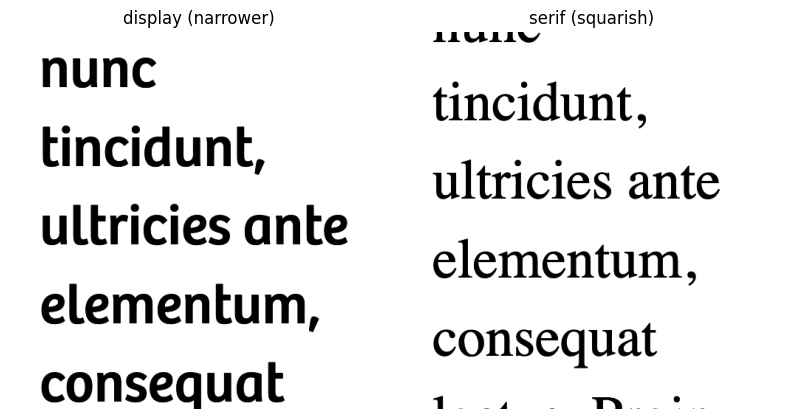

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Display the first image
ax1.imshow(cv2.imread('display-76px.png', cv2.IMREAD_GRAYSCALE), cmap='gray')
ax1.axis('off')  # Hide axes
ax1.set_title('display (narrower)')

# Display the second image
ax2.imshow(cv2.imread('serif-76px.png', cv2.IMREAD_GRAYSCALE), cmap='gray')
ax2.axis('off')  # Hide axes
ax2.set_title('serif (squarish)')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Across 7 different font sizes, the median squareness ratio for `display` images is less than `serif` images.

In [20]:
ts = ['display', 'serif']
szs = [18, 24, 36, 76, 240, 330, 420]
res = []

for t in ts:
    for sz in szs:
        image_path = f"{t}-{sz}px.png"
        sr = squareness_ratio(image_path)
        res.append([t, sz, sr])

res = pd.DataFrame(res, columns=['typeface', 'font-size', 'squareness-ratio'])
res.groupby('typeface')['squareness-ratio'].agg(['mean', 'median'])

,mean,median
typeface,,
display,0.763897,0.769231
serif,0.749344,0.823529


If we limit the font sizes to 18-76px, the difference is larger:

In [26]:
(
  res
    .query("`font-size` <= 76 and `font-size` >= 18")
    .groupby('typeface')['squareness-ratio']
    .agg(['mean', 'median'])
 )

,mean,median
typeface,,
display,0.762430,0.759615
serif,0.812604,0.823927


## Final Thoughts

Similar to aspect ratio the squareness ratio is a good candidate for distinguishing between typefaces. Even though these algorithms are similar, I'll keep them both in play for now and see how they perform on a larger and more diverse dataset of text images as they offer different insights:

- Squareness ratio:
  - Low for both short/wide and tall/narrow letters
  - Consistent for comparing square vs. non-square shapes
- Aspect ratio:
  - < 1 for tall/narrow letters
  - \> 1 for short/wide letters
  - Distinguishes between short/wide letters and tall/narrow letters


I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).